# Feature extraction

## Asymmetry

In [1]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import segmentation as sg
import importlib

from math import atan2, sqrt, sin, cos, pi

matplotlib.rcParams['figure.figsize'] = 8,6

uint8


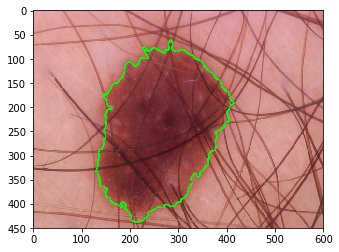

In [2]:
importlib.reload(sg)

img_a = cv2.imread('images/ISIC_0024779.jpg')
img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)

out_contour = sg.segment(img_a)

img_copy = img_a.copy()
cv2.drawContours(img_copy, [out_contour], -1, (0, 255, 0), 2)
plt.imshow(img_copy, 'gray')

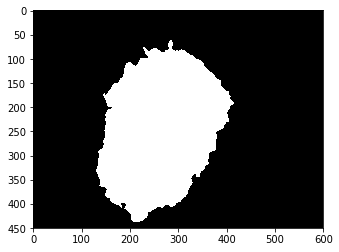

In [3]:
# Binarni prikaz detektovane konture
lesion_binary = np.zeros(img_a.shape, np.uint8)
lesion_binary = cv2.cvtColor(lesion_binary, cv2.COLOR_BGR2GRAY)
lesion_binary = cv2.drawContours(lesion_binary, [out_contour], -1, (255), thickness=-1)

plt.imshow(lesion_binary, 'gray')

0.7755454931785877
0.7755454931785877


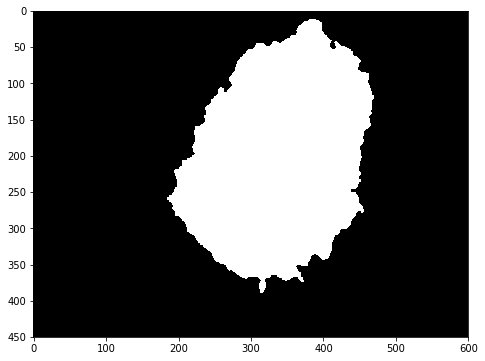

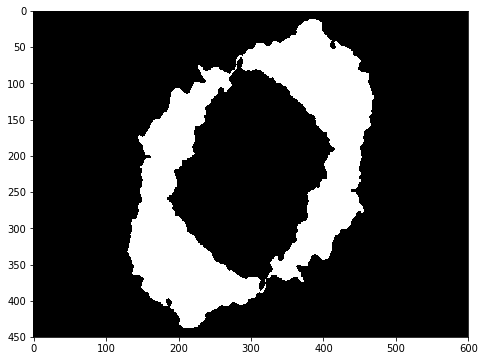

In [49]:
# Standardno rotiranje Afinom transformacijom - ne daje zeljene rezultate
center = tuple(np.array(lesion_binary.shape[1::-1])/2)
matrix = cv2.getRotationMatrix2D(center, 180, 1.0) # centar, ugao, faktor skaliranja
rotated_bin = cv2.warpAffine(lesion_binary, matrix, lesion_binary.shape[1::-1], flags = cv2.INTER_LINEAR)

plt.figure()
plt.imshow(rotated_bin, 'gray')

difference = cv2.bitwise_xor(lesion_binary, rotated_bin)
#difference = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(difference, 'gray')

deviation = (np.count_nonzero(difference)/np.count_nonzero(rotated_bin))
deviation2 = (np.count_nonzero(difference)/np.count_nonzero(lesion_binary))
print(deviation)
print(deviation2)

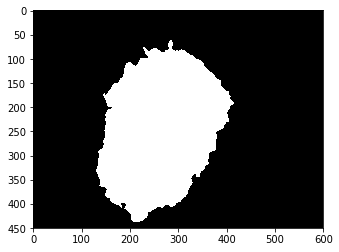

In [5]:
# Izracunavanje tezista konture na osnovu momenata
M = cv2.moments(out_contour)
if M["m00"] != 0:
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
else:
    cX, cY = 0, 0

lesion_binary_copy = lesion_binary.copy()
cv2.circle(lesion_binary_copy, (cX, cY), 1, (0, 0, 0), -1)
plt.imshow(lesion_binary_copy, 'gray')

In [6]:
# Metoda za iscrtavanje pronadjenih osa
def drawAxis(img, p_, q_, colour, scale):
    p = list(p_)
    q = list(q_)
    
    angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
    hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * cos(angle)
    q[1] = p[1] - scale * hypotenuse * sin(angle)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    # create the arrow hooks
    p[0] = q[0] + 9 * cos(angle + pi / 4)
    p[1] = q[1] + 9 * sin(angle + pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    p[0] = q[0] + 9 * cos(angle - pi / 4)
    p[1] = q[1] + 9 * sin(angle - pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)

(254, 245)


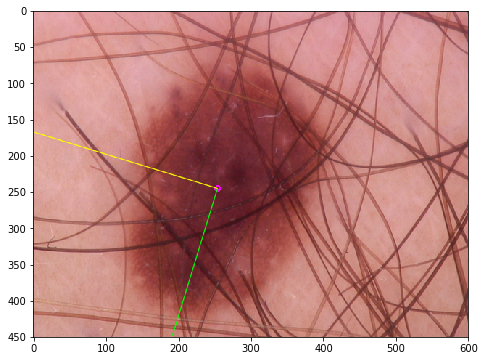

In [52]:
# Trazenje glavne i sporedne ose
img_axis = img_a.copy()
img_axis_bin = lesion_binary_copy.copy()
points = np.empty((len(out_contour),2), dtype=np.float64)
for i in range(points.shape[0]):
    points[i,0] = out_contour[i,0,0]
    points[i,1] = out_contour[i,0,1]

plt.imshow(points)

mean = np.empty((0))
mean, eigenvectors, eigenvalues = cv2.PCACompute2(points, mean)

pca_center = (int(mean[0,0]), int(mean[0,1]))
       
cv2.circle(img_axis, pca_center, 3, (255, 0, 255), 2)
print(pca_center)
p1 = (pca_center[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], pca_center[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
p2 = (pca_center[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], pca_center[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
drawAxis(img_axis, pca_center, p1, (0, 255, 0), 1)
drawAxis(img_axis, pca_center, p2, (255, 255, 0), 5)
angle = atan2(eigenvectors[0,1], eigenvectors[0,0])
angle_degrees = angle*180/pi
plt.imshow(img_axis)

0.7755454931785877
0.7755454931785877


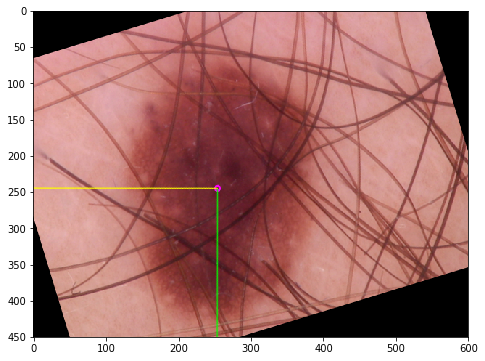

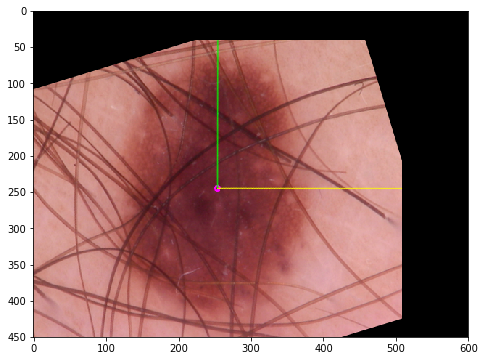

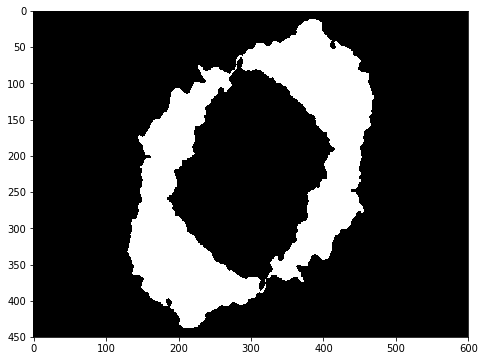

In [59]:
# Rotiranje oko glavne ose

prot1 = img_axis.copy()

# Centar konture oko koga se vrsi rotiranje
center = pca_center

matrix = cv2.getRotationMatrix2D(center, angle_degrees - 90, 1.0) # centar, ugao, faktor skaliranja

# Korekcija u odnosu na glavnu osu
corrected = cv2.warpAffine(prot1, matrix, lesion_binary.shape[1::-1], flags = cv2.INTER_LINEAR)

plt.figure()
plt.imshow(corrected)

matrix = cv2.getRotationMatrix2D(center, 180, 1.0)

rot_major = cv2.warpAffine(corrected, matrix, lesion_binary.shape[1::-1], flags = cv2.INTER_LINEAR)

plt.figure()
plt.imshow(rot_major)


difference = cv2.bitwise_xor(lesion_binary, rotated_bin)
#difference = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(difference, 'gray')

deviation = (np.count_nonzero(difference)/np.count_nonzero(rotated_bin))
deviation2 = (np.count_nonzero(difference)/np.count_nonzero(lesion_binary))
print(deviation)
print(deviation2)

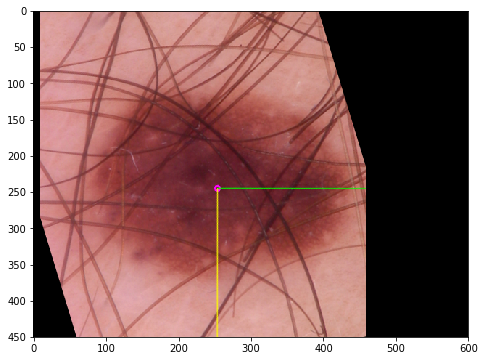

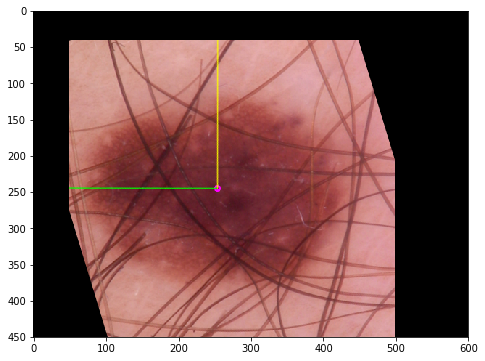

In [60]:
# Rotiranje oko sporedne ose

matrix = cv2.getRotationMatrix2D(center, 90, 1.0)

# Korekcija u odnosu na sporednu osu
interstage = cv2.warpAffine(corrected, matrix, lesion_binary.shape[1::-1], flags = cv2.INTER_LINEAR)

plt.figure()
plt.imshow(interstage)

matrix = cv2.getRotationMatrix2D(center, 180, 1.0)

rot_minor = cv2.warpAffine(interstage, matrix, lesion_binary.shape[1::-1], flags = cv2.INTER_LINEAR)

plt.figure()
plt.imshow(rot_minor)


### Examples

## Border

In [47]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import segmentation as sg
import importlib

matplotlib.rcParams['figure.figsize'] = 8,6

uint8


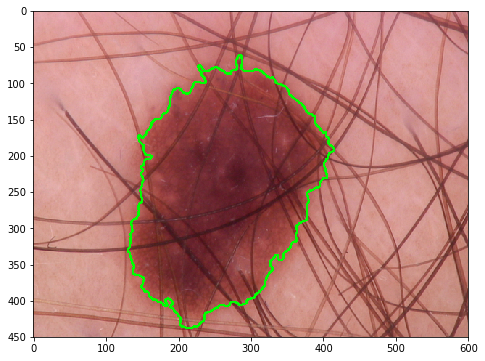

In [60]:
importlib.reload(sg)

img = cv2.imread('images/ISIC_0024779.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

out_contour = sg.segment(img)

img_copy = img.copy()
cv2.drawContours(img_copy, [out_contour], -1, (0, 255, 0), 2)
plt.imshow(img_copy)

Border regularity:  0.9178599517261953


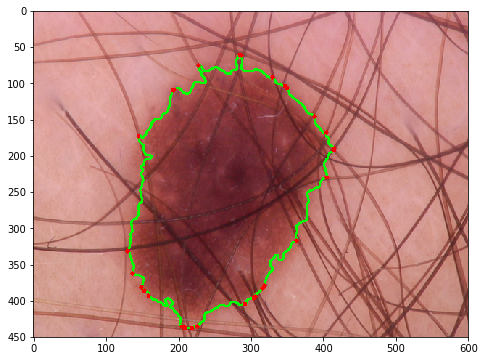

In [114]:
img_copy2 = img_copy.copy()

# Convex hull
hull = cv2.convexHull(out_contour, returnPoints=True)
cv2.drawContours(img_copy2, hull, -1, (255, 0, 0), 5)
plt.imshow(img_copy2)

countour_area = cv2.contourArea(out_contour);
hull_area = cv2.contourArea(hull)

B1 = countour_area / hull_area
print("Border regularity: ", B1)

0.9178599517261953


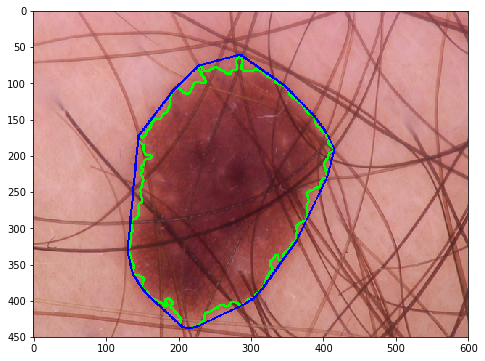

In [75]:
img_copy3 = img_copy.copy()

# Convex hull
hull = cv2.convexHull(out_contour, returnPoints=True)
cv2.drawContours(img_copy3, [hull], -1, (0, 0, 255), 2)
plt.imshow(img_copy3)

countour_area = cv2.contourArea(out_contour);
hull_area = cv2.contourArea(hull)

B1 = countour_area / hull_area
print(B1)

### Examples

In [62]:
import border as b
import importlib

uint8
0.8633220355817101


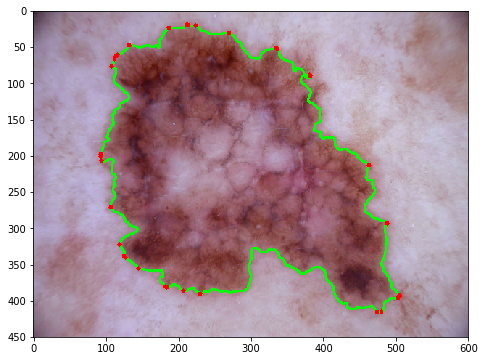

In [63]:
importlib.reload(b)
ii = cv2.imread('images/ISIC_0033834.jpg')
ii = cv2.cvtColor(ii, cv2.COLOR_BGR2RGB)
output_border, B1 = b.border_feature(ii)

print(B1)
plt.imshow(output_border)

uint8
0.8696679042028087


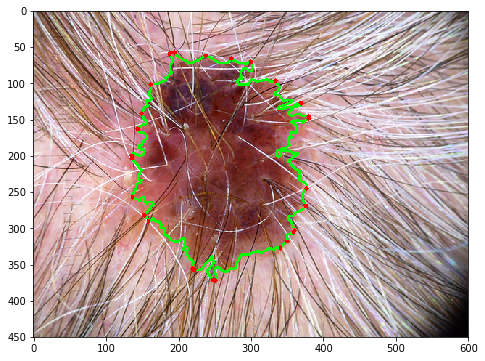

In [64]:
importlib.reload(b)
ii = cv2.imread('images/ISIC_0032214.jpg')
ii = cv2.cvtColor(ii, cv2.COLOR_BGR2RGB)
output_border, B1 = b.border_feature(ii)

print(B1)
plt.imshow(output_border)

uint8
0.8154725430120198


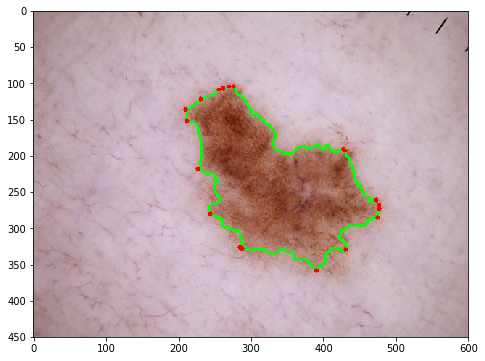

In [65]:
importlib.reload(b)
ii = cv2.imread('images/ISIC_0031550.jpg')
ii = cv2.cvtColor(ii, cv2.COLOR_BGR2RGB)
output_border, B1 = b.border_feature(ii)

print(B1)
plt.imshow(output_border)

uint8
0.7822980198505486


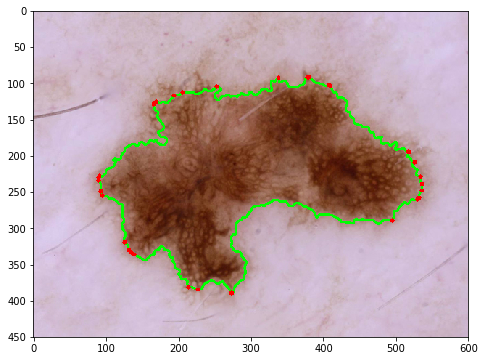

In [66]:
importlib.reload(b)
ii = cv2.imread('images/ISIC_0027066.jpg')
ii = cv2.cvtColor(ii, cv2.COLOR_BGR2RGB)
output_border, B1 = b.border_feature(ii)

print(B1)
plt.imshow(output_border)

uint8
0.957330752149405


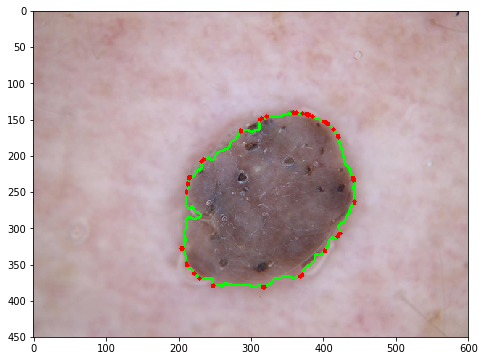

In [67]:
importlib.reload(b)
ii = cv2.imread('images/ISIC_0026644.jpg')
ii = cv2.cvtColor(ii, cv2.COLOR_BGR2RGB)
output_border, B1 = b.border_feature(ii)

print(B1)
plt.imshow(output_border)

uint8
0.9330282048272894


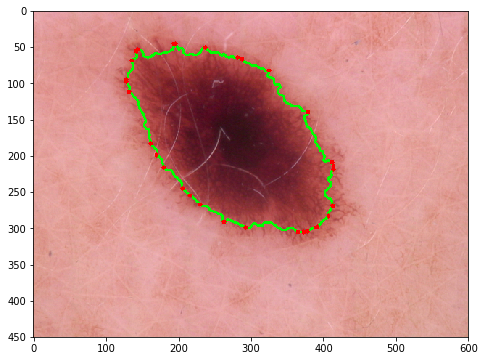

In [68]:
importlib.reload(b)
ii = cv2.imread('images/ISIC_0026639.jpg')
ii = cv2.cvtColor(ii, cv2.COLOR_BGR2RGB)
output_border, B1 = b.border_feature(ii)

print(B1)
plt.imshow(output_border)

uint8
0.8206497295676543


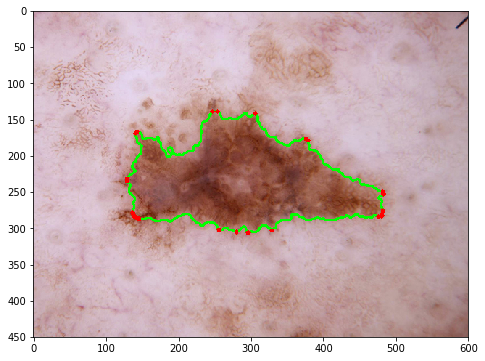

In [69]:
importlib.reload(b)
ii = cv2.imread('images/ISIC_0028899.jpg')
ii = cv2.cvtColor(ii, cv2.COLOR_BGR2RGB)
output_border, B1 = b.border_feature(ii)

print(B1)
plt.imshow(output_border)

uint8
0.9521050311492562


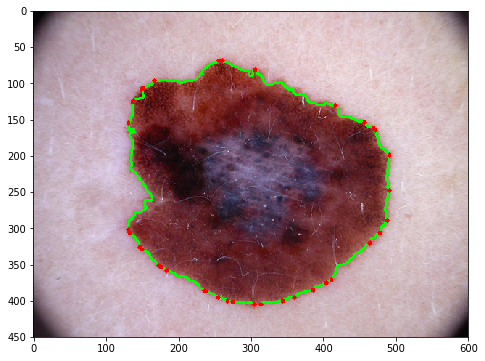

In [70]:
importlib.reload(b)
ii = cv2.imread('images/ISIC_0032637.jpg')
ii = cv2.cvtColor(ii, cv2.COLOR_BGR2RGB)
output_border, B1 = b.border_feature(ii)

print(B1)
plt.imshow(output_border)

## Color

In [13]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import segmentation as sg
import importlib

matplotlib.rcParams['figure.figsize'] = 8,6

uint8


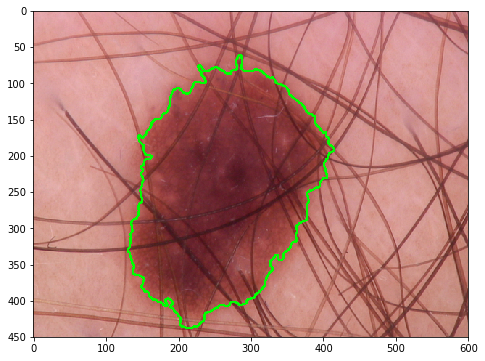

In [15]:
importlib.reload(sg)

img_c = cv2.imread('images/ISIC_0024779.jpg')
img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)

out_contour_c = sg.segment(img_c)

img_copy_c = img_c.copy()
cv2.drawContours(img_copy_c, [out_contour], -1, (0, 255, 0), 2)
plt.imshow(img_copy_c)